Category Prediction Accuracy: 0.50
Pronoun Prediction Accuracy: 0.50


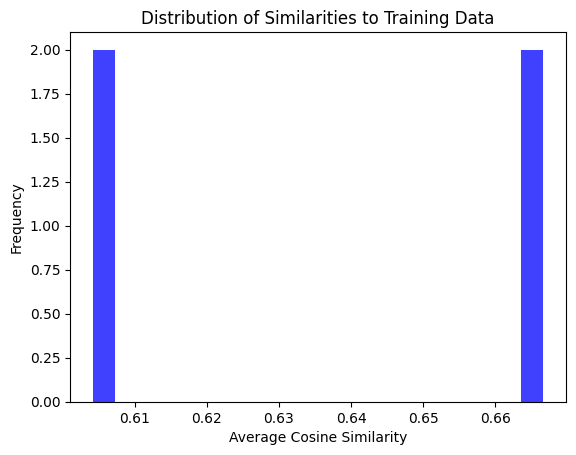

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load dataset function
def load_data():
    file_path = "Gender & Pronouns survey (Responses) - Form Responses 1.csv"
    data = pd.read_csv(file_path)

    # Select relevant columns
    input_columns = [
        "Based on your Physical Appearance, select one that best identifies you",
        "What is your Dressing Style?",
        "How do you identify yourself (Self-Identification)?"
    ]
    target_columns = ["What is your Gender Category?", "What is your Pronoun(s)?"]

    # Drop rows with missing values in essential columns
    data_cleaned = data[input_columns + target_columns].dropna()

    # Encode categorical text data into numerical values
    label_encoders = {}
    for col in input_columns + target_columns:
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le  # Store encoders for future use

    # Normalize input data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data_cleaned[input_columns].values)  # Normalize to range [0, 1]
    Y = data_cleaned[target_columns].values  # Last 2 columns as output
    return X, Y, label_encoders

# Similarity-based classification function
def classify_new_sample(X_train, Y_train, new_sample):
    similarities = cosine_similarity([new_sample], X_train)[0]
    
    # Find the most similar category based on average similarity scores
    category_similarities = {}
    for category in np.unique(Y_train[:, 0]):
        indices = np.where(Y_train[:, 0] == category)[0]
        category_similarities[category] = np.mean(similarities[indices])
    
    predicted_category = max(category_similarities, key=category_similarities.get)
    
    # Find the most similar pronoun based on the same method
    pronoun_similarities = {}
    for pronoun in np.unique(Y_train[:, 1]):
        indices = np.where(Y_train[:, 1] == pronoun)[0]
        pronoun_similarities[pronoun] = np.mean(similarities[indices])
    
    predicted_pronoun = max(pronoun_similarities, key=pronoun_similarities.get)
    
    return predicted_category, predicted_pronoun

# Main function
def main():
    X, Y, label_encoders = load_data()
    
    # Split data into training and testing
    num_train = int(0.8 * len(X))
    X_train, X_test = X[:num_train], X[num_train:]
    Y_train, Y_test = Y[:num_train], Y[num_train:]
    
    # Predict categories for test data
    predictions = [classify_new_sample(X_train, Y_train, sample) for sample in X_test]
    predictions = np.array(predictions)
    
    # Compute accuracy
    category_accuracy = np.mean(predictions[:, 0] == Y_test[:, 0])
    pronoun_accuracy = np.mean(predictions[:, 1] == Y_test[:, 1])
    
    print(f"Category Prediction Accuracy: {category_accuracy:.2f}")
    print(f"Pronoun Prediction Accuracy: {pronoun_accuracy:.2f}")
    
    # Visualizing similarity distribution
    similarities = [cosine_similarity([sample], X_train)[0] for sample in X_test]
    avg_similarities = [np.mean(sim) for sim in similarities]
    
    plt.figure()
    plt.hist(avg_similarities, bins=20, alpha=0.75, color='blue')
    plt.xlabel("Average Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarities to Training Data")
    plt.show()
    
if __name__ == "__main__":
    main()
